# U5 - Abdullah Barhoum (5041774) - Katharina Müller (5284090)

# Assignment 5: Block Matching and Harris Corner Detection
## Ex. 5.1 Dense Optical Flow by Block Matching
* implement the block matching method as shown in the lecture
* take two frames from the datasets "lane_detection" or "copter_flight" with variable distances in time (1, 2, x) and compute the vector flow field
* display a subset of flow vectors on the gray-value version of the first image, by drawing a respective line. adjust the grid density such that not too many vectors overlap (**RESULT**)

In [219]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
from skimage.draw import circle
import numpy as np
import cv2

In [220]:
# Footage from our Neurocopter project:
# http://berlinbiorobotics.blog/projects/neurocopter/
copter1 = io.imread('images/copter_flight/frame050.jpg')
copter2 = io.imread('images/copter_flight/frame052.jpg')

In [221]:
def generate_blocks(img, block_size = 10, block_stride = 150):
    H, W, C = img.shape
    half_block_size = block_size // 2
    block_centers = []
    for y in range(0, H, block_stride):
        for x in range(0, W, block_stride):
            block_centers.append((y, x))
    return block_centers   

In [222]:
def get_movement_vectors(img1, img2, blocks, block_size=10, window_size=100, in_window_stride=5):
    H, W, C = img1.shape
    in_image = lambda y, x: H > y >= 0 and W > x >= 0

    half_block_size = block_size // 2
    half_window_size = window_size // 2

    new_blocks = []
    for y, x in blocks:  # top left of block
        original_block = img1[y:y + block_size, x:x + block_size]

        # go through the search window in the second image
        top = y - (half_window_size - half_block_size)
        left = x - (half_window_size - half_block_size)

        min_difference = float('inf')
        most_similar_block = (0, 0)
        
        # w_y is window y, w_x is window x
        for w_y in range(top, top + window_size, in_window_stride):
            for w_x in range(left, left + window_size, in_window_stride):
                end_y = w_y + block_size
                end_x = w_x + block_size
                if not in_image(w_y, w_x) or not in_image(end_y, end_x):
                    continue
                current_block = img2[w_y:end_y , w_x:end_x]
                # difference
                diff = ((original_block - current_block)**2).sum()
                if diff < min_difference:
                    min_difference = diff
                    most_similar_block = (w_y, w_x)
        new_blocks.append(most_similar_block)
    return new_blocks

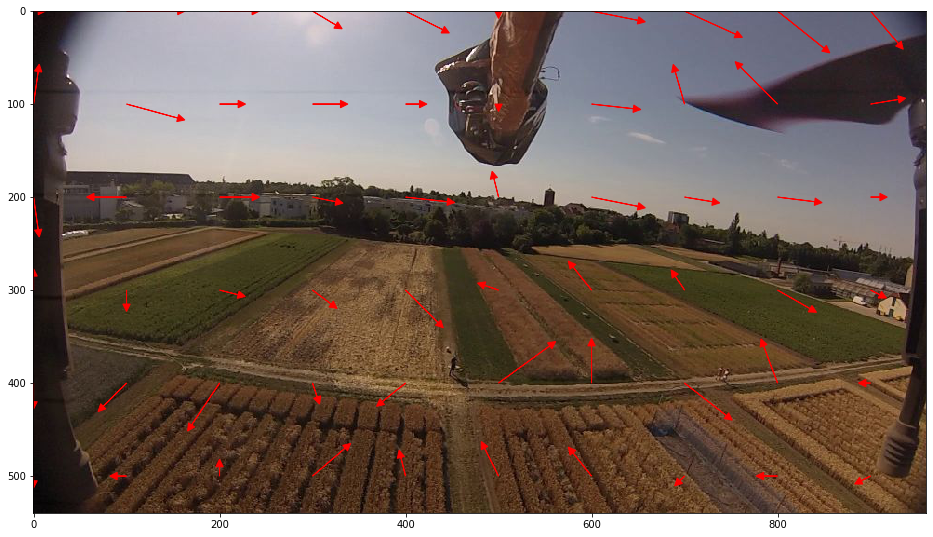

In [223]:
def run():
    block_size = 20
    block_stride = 100
    window_size = 100
    in_window_stride = 5
    
    blocks = generate_blocks(copter1, block_size, block_stride)
    new_blocks = get_movement_vectors(copter1, copter2, blocks, block_size,
                                      window_size, in_window_stride)
    plt.figure(figsize=(16, 16))
    for (y1, x1), (y2, x2) in zip(blocks, new_blocks):
        plt.arrow(x1, y1, x2 - x1, y2 - y1, color='red', head_width=8, head_length=8)
    plt.imshow(copter2)
    plt.show()

run()

## Ex. 5.2 Harris Corner Detection
* implement the Harris Corner Detector as discussed in the lecture
* compute corners in the first image and track them with Lucas-Kanade (use e.g. the function "calcOpticalFlowPyrLK" in OpenCV)
* mark the positions of your Harris corners and draw the flow vectors found by Lucas-Kanade on the gray-value versions of the first image (**RESULT**)

Algorithm: See Lecture 5 Slide 38/58 

* calculate gradients using sobel kernel Gx Gy
* calculate Gxx Gyy Gxy
* calculate sum of products of derivatives at each pixel
    * __NOTE__: products of derivatives are Gxx Gyy Gxy
* define at each pixel the matrix Hxy given in the lecture at slide 38/58
* compute ` R = det(Hxy) - k * trace(Hxy)^2`
    * where $k : [0.04, 0.06]$
    * trace = a + d from the matrix `[[ab],[cd]]`
        * or `mat[0][0] + mat[1][1]`
* compare R value to a threshold that defines a "good" corner
    * Threshold was 10,000
* save `x,y` for the best R values
* Dont forget to use `calcOpticalFlowPyrLK` from opencv2
    * you would probably need `reshape(100, 1, 2)` for the prevPoints parameter
* draw vectors from x, y to calculated x, y from calcOpticalFlowPyrLK

In [224]:
from scipy import ndimage as ndi

In [225]:
copter1b = color.rgb2gray(io.imread('images/copter_flight/frame050.jpg',0))
copter2b = color.rgb2gray(io.imread('images/copter_flight/frame052.jpg',0))

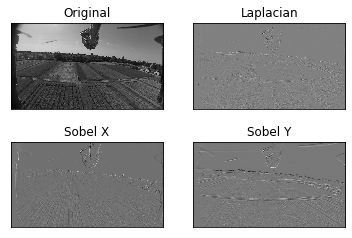

In [226]:
#Gradient Images for Image 1:
laplacian = cv2.Laplacian(copter1b,cv2.CV_64F)
sobelx_1 = cv2.Sobel(copter1b,cv2.CV_64F,1,0,ksize=5)
sobely_1 = cv2.Sobel(copter1b,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(copter1b,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx_1,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely_1,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

In [227]:
Ixx = np.square(sobelx_1)
Iyy = np.square(sobely_1)
Ixy = np.multiply(Ixx, Iyy)

#Adjusted after getting terrible results with pure calculation above
#By blurring we can remove a lot of the odder corners detected in the filed and focus on better corners on trees
Ixx_better = ndi.gaussian_filter(sobelx_1**2, sigma=1)
Ixy_better = ndi.gaussian_filter(sobely_1*sobelx_1, sigma=1)
Iyy_better = ndi.gaussian_filter(sobely_1**2, sigma=1)

### Necessary Formulas/Calculations to get R vlue:
k = 0.05
#### determinant:
detA = Ixx * Iyy - Ixy ** 2
#### trace:
traceA = Ixx + Iyy   
R = detA - k * traceA ** 2

#### Non-maximum suppression:
Edge if r < 0
Corner if r > 0
Line/Flat if r = 0

In [228]:
def non_maximum_suppression (img, Ixx, Iyy, Ixy):
    height, width = img.shape
    harris_r = []
    for y in range(height):
        for x in range(width):
            Sxx = np.sum(Ixx[y:y+1, x:x+1])
            Syy = np.sum(Iyy[y:y+1, x:x+1])
            Sxy = np.sum(Ixy[y:y+1, x:x+1])

            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)
            harris_r.append(r)
    return harris_r

In [229]:
harris_r = non_maximum_suppression(copter1b, Ixx, Iyy, Ixy)
print('Maximum r value:', max(harris_r))
harris_r_better = non_maximum_suppression(copter1b, Ixx_better, Iyy_better, Ixy_better)
print('Maximum r value with blurr:', max(harris_r_better))

Maximum r value: 0.15999890034458167
Maximum r value with blurr: 58081.389656559346


In [230]:
# threshold = 0 for nomal and 0.5 for blurred
def all_corners (harris_r, threshold):
    corners = np.zeros_like(harris_r)
    edges = np.zeros_like(harris_r)
    for idx, value in enumerate(harris_r):
        if value > threshold:
            corners[idx] = 255
    return corners

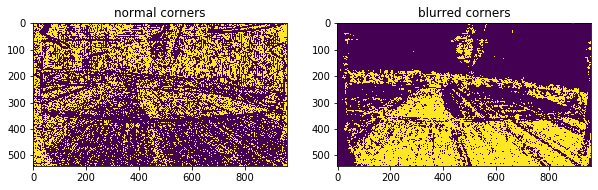

In [231]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
ax[0].set_title("normal corners")
ax[0].imshow(all_corners (harris_r, 0).reshape((540,960)))
ax[1].set_title("blurred corners")
ax[1].imshow(all_corners (harris_r_better, 0.5).reshape((540,960)))
plt.show()

In [232]:
#Threshold:
# threshold = -10000 for normal and 10000 for blurred version
def best_corners (harris_r, threshold): 
    best_corners = []
    for i, value in enumerate (harris_r):
        if value > threshold:
            best_corners.append(value)
    sorted_r_list= sorted(best_corners, reverse=True)
    best_100 = sorted_r_list[:100]
    return best_100

In [233]:
best_100 = best_corners(harris_r, -10000)
print('Best corner r value:', max(best_100))

best_100_blurred = best_corners(harris_r_better, 10000)
print('Best corner r value with blurr:', max(best_100_blurred))

Best corner r value: 0.15999890034458167
Best corner r value with blurr: 58081.389656559346


In [234]:
def get_indecies (harris_r, best_100):
    reshaped_harris_r = np.reshape(harris_r, (540,960))
    #get idexes for best_100 r values
    result = []
    for idx, value in enumerate(best_100):
        result.append(np.where(reshaped_harris_r == value))
    a = np.asarray(result)
    return a

In [235]:
best_100_points = get_indecies(harris_r, best_100)
print('Best corner coordinates:', best_100_points[0])

best_100_points_blurred = get_indecies(harris_r_better, best_100_blurred)
print('Best corner coordinates with blurr:', best_100_points_blurred[0])

Best corner coordinates: [[502]
 [180]]
Best corner coordinates with blurr: [[ 89]
 [491]]


In [236]:
# Reformat array to input into calcOpticalFlowPyrLK
best_points = best_100_points.reshape(100, 1, 2).astype(np.float32)
print(best_points[0])
best_points_blurred = best_100_points_blurred.reshape(100, 1, 2).astype(np.float32)
print('Blurred: ', best_points_blurred[0])

[[502. 180.]]
Blurred:  [[ 89. 491.]]


In [237]:
# read images in correct format for calcOpticalFlowPyrLK
img = cv2.imread("images/copter_flight/frame050.jpg", 0);
img2 = cv2.imread("images/copter_flight/frame052.jpg", 0);

In [276]:
#Use Default for calcOpticalFlowPyrLK:
def optical_flow (img, img2, best_points):
    mask = np.zeros_like(img)
    #Default Values from opencv
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(img, img2, best_points, None, **lk_params)
    # Select good points
    good_new = p1 #[st==1]
    #print(good_new.shape)
    return good_new

In [293]:
p0 = best_points
good_old = p0[st==1]
good_old = good_old #.reshape(100, -1)
good_new = optical_flow(img, img2, best_points)[st==1] #.reshape(100, -1)
print(good_new[0])

p0_blurred = best_points_blurred
good_old_blurred = p0_blurred
good_old_blurred = good_old_blurred.reshape(100, -1)
good_new_blurred = optical_flow(img, img2, best_points_blurred).reshape(100, -1)
print(good_new_blurred[0])

[500.39133 192.51244]
[ 88.17798 484.64374]


### Result without blurring Ixx, Iyy and Ixy: 

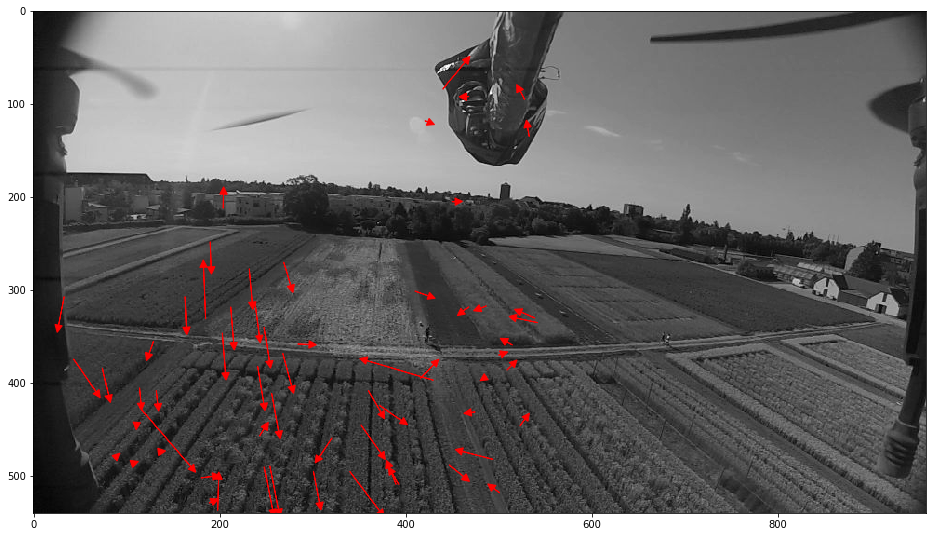

In [294]:
plt.figure(figsize=(16, 16))
for (y1, x1), (y2, x2) in zip(good_old, good_new):
    plt.arrow(x1, y1, x2 - x1, y2 - y1, color='red', head_width=8, head_length=8)
    plt.imshow(img, cmap = 'gray')
plt.show()

### Result with blurring Ixx, Iyy and Ixy: 

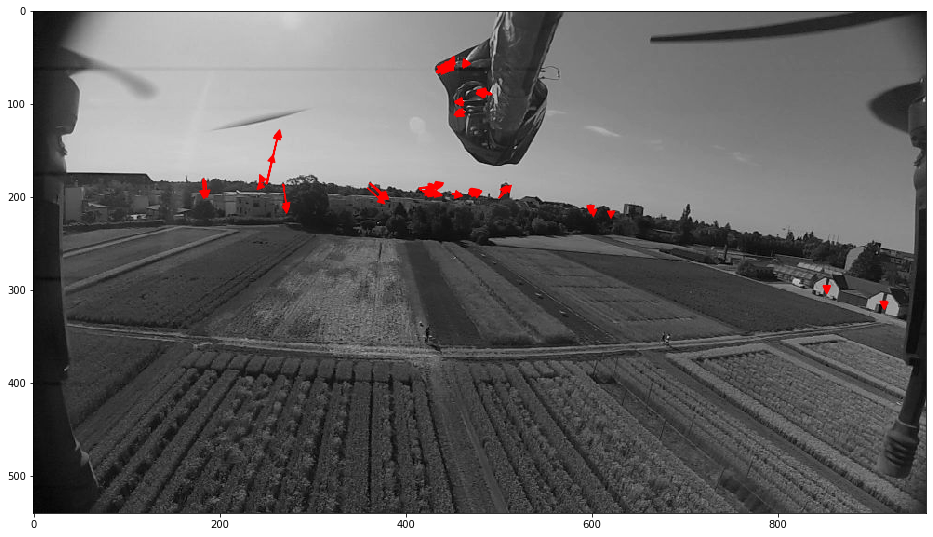

In [292]:
plt.figure(figsize=(16, 16))
for (y1, x1), (y2, x2) in zip(good_old_blurred, good_new_blurred):
    plt.arrow(x1, y1, x2 - x1, y2 - y1, color='red', head_width=8, head_length=8)
    plt.imshow(img, cmap = 'gray')
plt.show()